In [1]:
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np
import skimage
import os
import sys
import random
import torch

from scripts.amg import write_masks_to_folder
from project_files.sam_extractor import extract_images
from project_files.utils import get_classes
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)  
    
random.seed(42)
np.random.seed(42)

### 1. Load your image

Load image ./test_images/green_curry.jpg? 'y' or alternative file path: 
./test_images/test.jpeg

Loading image ./test_images/test.jpeg


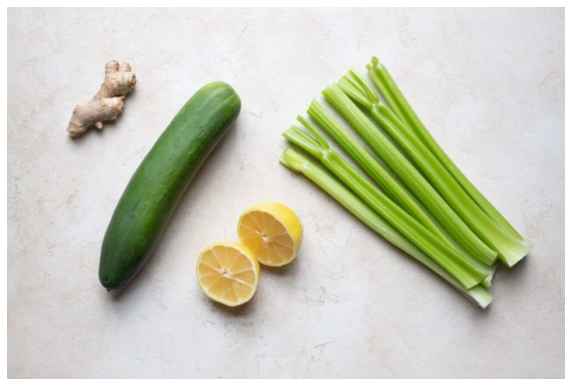

In [2]:
file_name = "green_curry"
image_path = f"./test_images/{file_name}.jpg"

prompt = f"Load image {image_path}? 'y' or alternative file path: \n"
answer = input(prompt).lower()

if answer != 'y':
    image_path = answer
    
print(f"\nLoading image {image_path}")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

### 2. Segment your image with SAM

In [3]:
checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device="cpu"

sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(model=sam, points_per_side=32, pred_iou_thresh=0.925,
    stability_score_thresh=0.9, min_mask_region_area=200)
masks = mask_generator.generate(image)
print(f"Generated {len(masks)} masks. You will be able to revise the selection.")

Generated 18 masks. You will be able to revise the selection.


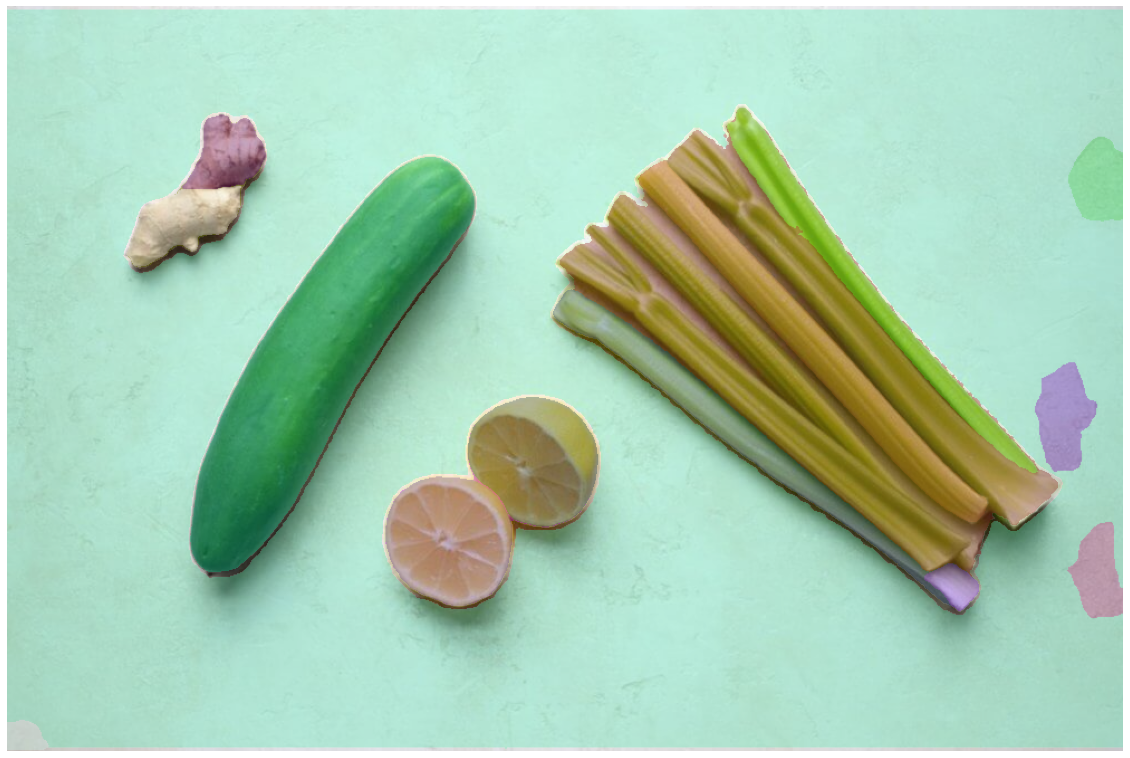

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()

In [5]:
session = f"{file_name}_{int(time.time())}"
mask_path = f"temp/{session}/"
os.makedirs(mask_path, exist_ok=True)
write_masks_to_folder(masks, mask_path)

### 3. Verify correctness of masks

In [6]:
%%capture
processed_path = f"temp/extracted/{session}"
segmented_images = extract_images(mask_path, image_path, processed_path)

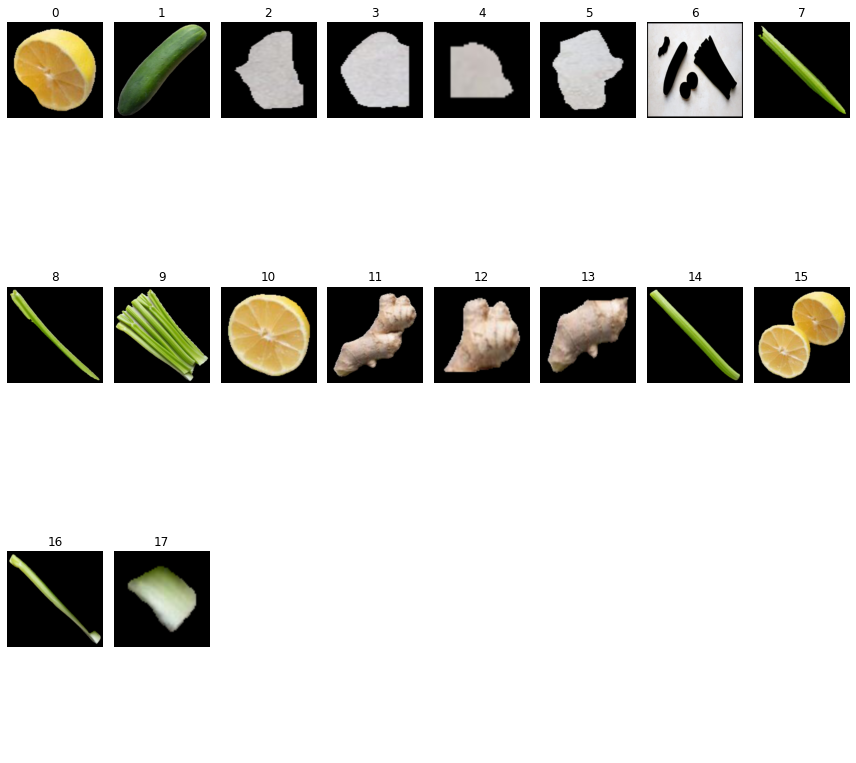

In [7]:
grid_length = int(np.ceil(len(segmented_images) / 8))
fig, axes = plt.subplots(grid_length, 8, figsize=(12, 12))

for index, ax in enumerate(axes.reshape(-1)): 
    if index >= len(segmented_images):
        ax.set_axis_off()
        continue
        
    ax.set_title(str(index))
    ax.set_axis_off()
    ax.imshow(segmented_images[index])

fig.tight_layout()
plt.show()

Input the IDs of masks which should be excluded from further processing

            in the format ID1 ID2 ID3:     2 3 4 5 6 15


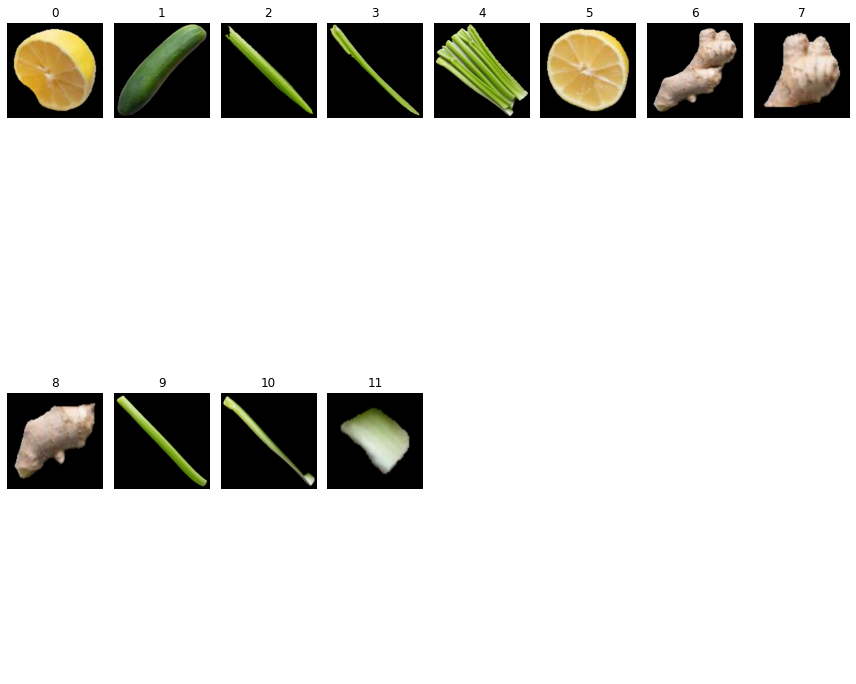

In [8]:
prompt = f"""Input the IDs of masks which should be excluded from further processing\n
            in the format ID1 ID2 ID3:     """
answer = input(prompt).lower()
answer = [int(index) for index in answer.split(" ")]

segmented_images = [img for index, img in enumerate(segmented_images) if index not in answer]

grid_length = int(np.ceil(len(segmented_images) / 8))
fig, axes = plt.subplots(grid_length, 8, figsize=(12, 12))

for index, ax in enumerate(axes.reshape(-1)): 
    if index >= len(segmented_images):
        ax.set_axis_off()
        continue
        
    ax.set_title(str(index))
    ax.set_axis_off()
    ax.imshow(segmented_images[index])

fig.tight_layout()
plt.show()

### 4. Run classification

In [9]:
%%capture
model  = resnet50(weights=ResNet50_Weights)

model.fc = torch.nn.Linear(model.fc.in_features, 43)
model.fc.load_state_dict(torch.load("models/linear_v2.pth"))

tf = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(224)])

In [10]:
classes = get_classes()
predictions = []

with torch.no_grad():
    model.eval()
#     model.float()
    
    for segment in segmented_images:
#         out = model(tf(segment).unsqueeze(0).float())
        out = model(tf(segment).float().unsqueeze(0))
        y_pred = torch.argmax(out).item()
        predictions.append(classes[y_pred])

### 5. Verify correctness of predictions

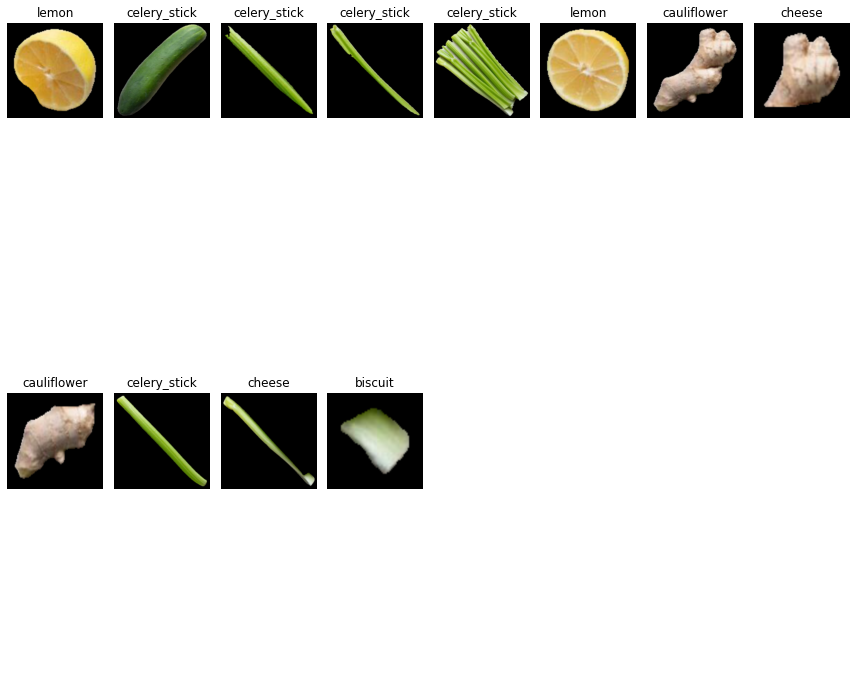

In [11]:
fig, axes = plt.subplots(grid_length, 8, figsize=(12, 12))

for index, ax in enumerate(axes.reshape(-1)): 
    if index >= len(segmented_images):
        ax.set_axis_off()
        continue
        
    ax.set_title(predictions[index])
    ax.set_axis_off()
    ax.imshow(segmented_images[index])

fig.tight_layout()
plt.show()

### 6. Verify correctness of weight estimates

### 7. Get nutritional value estimate